In [1]:
# Imports basics
import numpy as np
import h5py
import json
import setGPU
import sklearn
import corner
import os
import scipy
# Imports neural net tools
import itertools
import torch
import torch.nn as nn
from torch.autograd.variable import *
import torch.optim as optim
from fast_soft_sort.pytorch_ops import soft_rank
import matplotlib.pyplot as plt

setGPU: Setting GPU to: 0


/uscms_data/d3/jkrupa/flat/mambaforge/envs/IN/lib/python3.10/site-packages/fast_soft_sort-0.1-py3.10.egg/fast_soft_sort/third_party/isotonic.py:39: UserWarning: Numba could not be imported. Code will run much more slowly. To install, please run 'pip install numba'.


In [2]:
# Sets controllable values

particlesConsidered = 50
particlesPostCut = 50
entriesPerParticle = 4
eventDataLength = 6
decayTypeColumn = -1
datapoints = 1400000
#datapoints = len(totalData)
modelName = "IN_FlatSamples_EighthQCDEighthSig_50particles_pTsdmassfilling_dRlimit08"


Extracting
(3074667, 207)
Preparing Data
(3074667, 207)
3074667 [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
3074667 [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

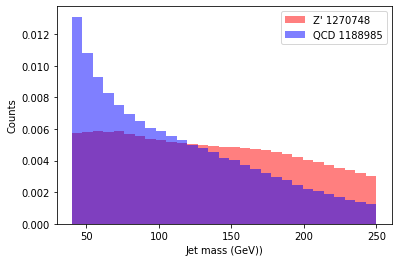

In [3]:
# Creates Training Data

# Opens files and reads data

print("Extracting")
n_encoded_nodes = 2
weightClr = 1
weightCorr1 = 1
weightCorr2 = 0
msd_sig_min = 40.
msd_sig_max = 250.
loss_text="%iD encoder, $\lambda_{CLR}$=%i, $\lambda_{corr1}$=%i, $\lambda_{corr2}$=%i"%(n_encoded_nodes, weightClr, weightCorr1, weightCorr2)

label=f'contrastiveBarlow_{n_encoded_nodes}_dimensions_{weightClr}Clr_{weightCorr1}Corr1_{weightCorr2}Corr2_{msd_sig_min}sigMassMin_{msd_sig_max}sigMassMax'
outdir = '/uscms_data/d3/jkrupa/flat/FlatSamples/plots/'+label
os.system(f'mkdir -p {outdir}')
fOne = h5py.File("/uscms_data/d3/eamoreno/FlatSamples/data/FullQCD_FullSig_Zqq_noFill_dRlimit08_50particlesordered_genMatched50.h5", 'r')
totalData = fOne["deepDoubleQ"][:]
print(totalData.shape)

print("Preparing Data")

particleDataLength = particlesConsidered * entriesPerParticle

np.random.seed(42)
np.random.shuffle(totalData)

#trainingDataLength = int(datapoints*0.8)
#validationDataLength = int(datapoints*0.1)

mask = [i>40 for i in totalData[:, eventDataLength-1]]
mask2 = []
for i in range(totalData.shape[0]):
    if totalData[i,-1]==0:
        mask2.append(True)
    else:
        mass = totalData[i,eventDataLength-1]
        if (mass > msd_sig_min) and (mass < msd_sig_max):
            mask2.append(True)
        else:
            mask2.append(False)
            
tot_mask = mask and mask2
print(totalData.shape)
print(len(tot_mask), tot_mask[-100:])
print(len(mask), mask[-100:])
print(len(mask2), mask2[-100:])

totalData = totalData[tot_mask]
datapoints = min(sum(totalData[:,-1]==1), sum(totalData[:,-1]==0))
print("datapoints",datapoints)
trainingDataLength = int(len(totalData)*0.8)
validationDataLength = int(len(totalData)*0.1)
print(totalData)
labels = totalData[:, decayTypeColumn:]
particleData = totalData[:, eventDataLength:particleDataLength + eventDataLength]
eventData = totalData[:, :eventDataLength]
jetMassData = totalData[:, eventDataLength-1] #last entry in eventData (zero indexing)


######### Training Data ###############
eventTrainingData = np.array(eventData[0:trainingDataLength],dtype=np.float16)
jetMassTrainingData = np.array(jetMassData[0:trainingDataLength],dtype=np.float16)
particleTrainingData = np.transpose(
    particleData[0:trainingDataLength, ].reshape(trainingDataLength, 
                                                 entriesPerParticle, 
                                                 particlesConsidered),
                                                 axes=(0, 1, 2))
particleTrainingData = particleTrainingData.astype(np.float16)

trainingLabels = np.array([[i, 1-i] for i in labels[0:trainingDataLength]]).reshape((-1, 2))

torch.save(torch.Tensor(particleTrainingData),f"{outdir}/{label}_particleTrainingData.pt")
torch.save(torch.Tensor(jetMassTrainingData),f"{outdir}/{label}_jetMassTrainingData.pt")
torch.save(torch.Tensor(trainingLabels),f"{outdir}/{label}_trainingLabels.pt")


########## Validation Data ##########
eventValidationData = np.array(eventData[trainingDataLength:trainingDataLength + validationDataLength])
jetMassValidationData = np.array(jetMassData[trainingDataLength:trainingDataLength + validationDataLength])
particleValidationData = np.transpose(
    particleData[trainingDataLength:trainingDataLength + validationDataLength, ].reshape(validationDataLength,
                                                                                         entriesPerParticle,
                                                                                         particlesConsidered),
                                                                                         axes=(0, 1, 2))
validationLabels = np.array([[i, 1-i] for i in labels[trainingDataLength:trainingDataLength + validationDataLength]]).reshape((-1, 2))



########### Testing Data ############
particleTestData = np.transpose(particleData[trainingDataLength + validationDataLength:,].reshape(
    len(particleData) - trainingDataLength - validationDataLength, entriesPerParticle, particlesConsidered),
                                axes=(0, 1, 2))
testLabels = np.array(labels[trainingDataLength + validationDataLength:])

print('Selecting particlesPostCut')
particleTrainingData = particleTrainingData[:, :particlesPostCut]
particleValidationData = particleValidationData[:, :particlesPostCut]

particlesConsidered = particlesPostCut

# Separating signal and bkg arrays
particleTrainingDataSig = particleTrainingData[trainingLabels[:,0].astype(bool)]
particleTrainingDataBkg = particleTrainingData[trainingLabels[:,1].astype(bool)]
particleValidationDataSig = particleValidationData[validationLabels[:,0].astype(bool)]
particleValidationDataBkg = particleValidationData[validationLabels[:,1].astype(bool)]
particleTrainingLabelSig = trainingLabels[trainingLabels[:,0].astype(bool)]
particleTrainingLabelBkg = trainingLabels[trainingLabels[:,1].astype(bool)]

# Jet mass for correlation
jetMassTrainingDataSig = jetMassTrainingData[trainingLabels[:,0].astype(bool)]
jetMassTrainingDataBkg = jetMassTrainingData[trainingLabels[:,1].astype(bool)]
jetMassValidationDataSig = jetMassValidationData[validationLabels[:,0].astype(bool)]
jetMassValidationDataBkg = jetMassValidationData[validationLabels[:,1].astype(bool)]


fig,ax = plt.subplots()
ax.hist(jetMassTrainingDataSig,color="r",bins=np.linspace(40,250,30),alpha=0.5,label=f"Z' {len(jetMassTrainingDataSig)}",density=True)
ax.hist(jetMassTrainingDataBkg,color="b",bins=np.linspace(40,250,30),alpha=0.5,label=f"QCD {len(jetMassTrainingDataBkg)}",density=True)
plt.legend(loc="best")
ax.set_xlabel("Jet mass (GeV))")
ax.set_ylabel("Counts")
plt.savefig(outdir+"/massHist.png")
plt.show()

In [4]:
# Defines the interaction matrices
class GraphNetnoSV(nn.Module):
    def __init__(self, n_constituents, n_targets, params, hidden, De=5, Do=6, softmax=False):
        super(GraphNetnoSV, self).__init__()
        self.hidden = int(hidden)
        self.P = params
        self.Nv = 0 
        self.N = n_constituents
        self.Nr = self.N * (self.N - 1)
        self.Nt = self.N * self.Nv
        self.Ns = self.Nv * (self.Nv - 1)
        self.Dr = 0
        self.De = De
        self.Dx = 0
        self.Do = Do
        self.S = 0
        self.n_targets = n_targets
        self.assign_matrices()
           
        self.Ra = torch.ones(self.Dr, self.Nr)
        self.fr1 = nn.Linear(2 * self.P + self.Dr, self.hidden).cuda()
        self.fr2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3 = nn.Linear(int(self.hidden/2), self.De).cuda()
        self.fr1_pv = nn.Linear(self.S + self.P + self.Dr, self.hidden).cuda()
        self.fr2_pv = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fr3_pv = nn.Linear(int(self.hidden/2), self.De).cuda()
        
        self.fo1 = nn.Linear(self.P + self.Dx + (self.De), self.hidden).cuda()
        self.fo2 = nn.Linear(self.hidden, int(self.hidden/2)).cuda()
        self.fo3 = nn.Linear(int(self.hidden/2), self.Do).cuda()
        
        self.fc_fixed = nn.Linear(self.Do, self.n_targets).cuda()
        self.activation = torch.nn.Sigmoid()
            
    def assign_matrices(self):
        self.Rr = torch.zeros(self.N, self.Nr)
        self.Rs = torch.zeros(self.N, self.Nr)
        receiver_sender_list = [i for i in itertools.product(range(self.N), range(self.N)) if i[0]!=i[1]]
        for i, (r, s) in enumerate(receiver_sender_list):
            self.Rr[r, i] = 1
            self.Rs[s, i] = 1
        self.Rr = (self.Rr).cuda()
        self.Rs = (self.Rs).cuda()

    def forward(self, x):
        ###PF Candidate - PF Candidate###
        Orr = self.tmul(x, self.Rr)
        Ors = self.tmul(x, self.Rs)
        B = torch.cat([Orr, Ors], 1)
        ### First MLP ###
        B = torch.transpose(B, 1, 2).contiguous()
        B = nn.functional.relu(self.fr1(B.view(-1, 2 * self.P + self.Dr)))
        B = nn.functional.relu(self.fr2(B))
        E = nn.functional.relu(self.fr3(B).view(-1, self.Nr, self.De))
        del B
        E = torch.transpose(E, 1, 2).contiguous()
        Ebar_pp = self.tmul(E, torch.transpose(self.Rr, 0, 1).contiguous())
        del E
        

        ####Final output matrix for particles###
        

        C = torch.cat([x, Ebar_pp], 1)
        del Ebar_pp
        C = torch.transpose(C, 1, 2).contiguous()
        ### Second MLP ###
        C = nn.functional.relu(self.fo1(C.view(-1, self.P + self.Dx + (self.De))))
        C = nn.functional.relu(self.fo2(C))
        O = nn.functional.relu(self.fo3(C).view(-1, self.N, self.Do))
        del C

        
        #Taking the sum of over each particle/vertex
        N = torch.sum(O, dim=1)
        del O
        
        ### Classification MLP ###

        N = self.fc_fixed(N)
        
        if softmax:
            N = nn.Softmax(dim=1)(N)
        
        return self.activation(N)
            
    def tmul(self, x, y):  #Takes (I * J * K)(K * L) -> I * J * L 
        x_shape = x.size()
        y_shape = y.size()
        return torch.mm(x.view(-1, x_shape[2]), y).view(-1, x_shape[1], y_shape[1])
    

class DNN(nn.Module):
    def __init__(self, n_targets):
        super(DNN, self).__init__()
        #self.flat = torch.flatten()
        self.f0 = nn.Linear(200, 400).cuda()
        self.f0b = nn.Linear(400, 400).cuda()
        self.f1 = nn.Linear(400, 100).cuda()
        self.f2 = nn.Linear(100, 50).cuda()
        self.f3 = nn.Linear(50, 10).cuda()
        self.f4 = nn.Linear(10, n_targets).cuda()
        self.activation = torch.nn.ReLU()
    def forward(self, x): 
        x = torch.flatten(x,start_dim=1)
        x = self.activation(self.f0(x))
        #x = self.f0b(x)
        x = self.activation(self.f1(x))
        x = self.activation(self.f2(x))
        x = self.activation(self.f3(x))
        x = self.f4(x)
        return(x)
    

class simple_MLP(torch.nn.Module):
    def __init__(self,input_size=5,out_channels=2,act_out=True,nlayers=4,nhidden=50,batchnorm=True):
        super().__init__()
        self.bn  = torch.nn.BatchNorm1d(input_size).cuda()
        self.fc1 = torch.nn.Linear(input_size, 50, bias=False).cuda()
        self.ac1 = torch.nn.ReLU().cuda()
        self.dp1 = torch.nn.Dropout(p=0.2).cuda()
        self.fc2 = torch.nn.Linear(50, 30).cuda()
        self.ac2 = torch.nn.ReLU().cuda()
        self.fc3 = torch.nn.Linear(30, 10).cuda()
        self.ac3 = torch.nn.ReLU().cuda()
        self.fc4 = torch.nn.Linear(10, out_channels).cuda()
        self.output = torch.nn.Sigmoid().cuda()
        self.out_channels = out_channels
        self.act_out = act_out
        self.nlayers = nlayers
        self.runbatchnorm = batchnorm
        
    def forward(self, x):
        x = self.bn(x)
        x = self.fc1(x)
        #x = self.ac1(x)
        x = self.fc2(x)
        #x = self.ac2(x)
        x = self.fc3(x)
        #x = self.ac3(x)
        x = self.fc4(x)
        #if self.runbatchnorm:
        #    x = self.batchnorm(x)
        #if self.act_out:
        x = self.output(x)
        return x

In [5]:
# Define losses 
class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        self.device = torch.device('cuda:0')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        #self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        # loss
        c_diff = (c - torch.eye(D, device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss

class CorrLoss(nn.Module):
    def __init__(self, corr=False,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.cpu().reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        ret = (pred * target).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret 
    
    def forward(self, features, labels):
        return self.spearman(features,labels)
    
class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        #self.device = torch.device('cpu')

    def forward(self, x, y):
        self.device = (torch.device('cuda')if x.is_cuda else torch.device('cpu'))
        
        x_scale = x
        y_scale = y
        repr_loss = F.mse_loss(x_scale, y_scale)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x_scale - x_scale.mean(dim=0)
        y = y_scale - y_scale.mean(dim=0)
        N = x_scale.size(0)
        D = x_scale.size(1)
        
        std_x = torch.sqrt(x_scale.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y_scale.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x_scale.T @ x_scale) / (N - 1)
        cov_y = (y_scale.T @ y_scale) / (N - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(D) + off_diagonal(cov_y).pow_(2).sum().div(D)

        #loss = (self.lambda_param * repr_loss + self.mu_param * std_loss+ self.nu_param * cov_loss)
        #print(repr_loss,cov_loss,std_loss)
        return repr_loss,cov_loss,std_loss

Epoch 0



  0%|                                                                                                                                                   | 0/198 [00:00<?, ?it/s]


trainingv1.shape torch.Size([6000, 4, 50])
tensor([[[ 0.1519,  0.1099,  0.1014,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1306,  0.1573, -0.0945,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0177,  0.0558, -0.0609,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1604,  0.1471,  0.0788,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0099,  0.0526,  0.1177,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0465,  0.0560,  0.0247,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000, -1.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.3025,  0.1543,  0.0909,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0219,  0.0166, -0.0117,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0211,  0.0229,  0.0353,  ...,  0.0000,  0.0000,  0.0000],
         [-1.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.1884,  0.1624,  0.1501,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0

NameError: name 'out1' is not defined

<Figure size 432x288 with 0 Axes>

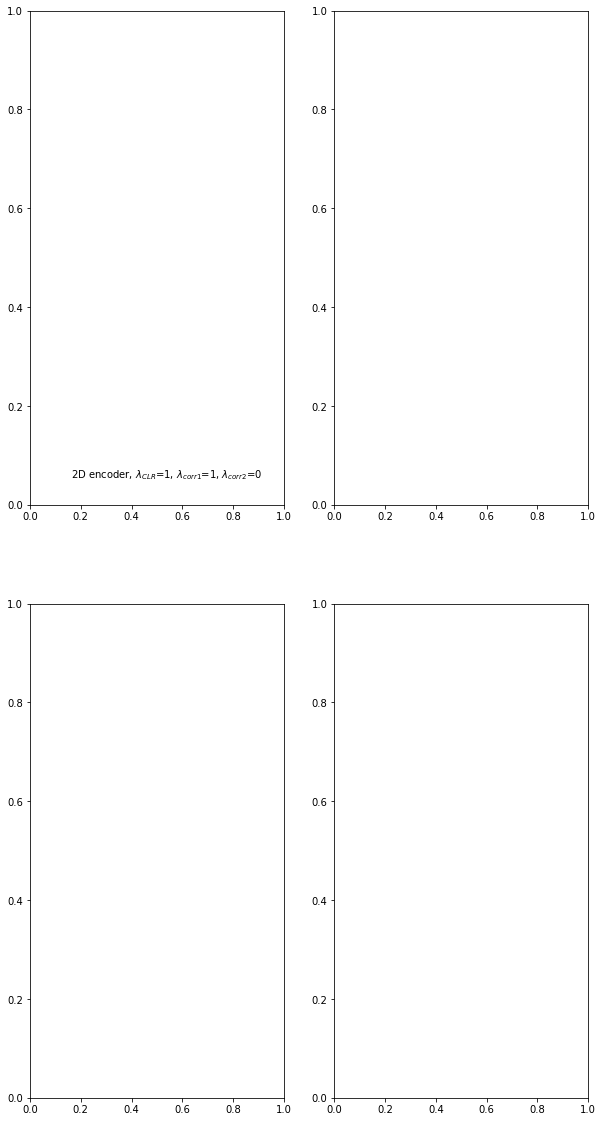

In [6]:
##### Training Loop Barlow DNN #########

batchSize = 6000
n_epochs = 10

gnn = DNN(n_encoded_nodes)
    
loss = nn.BCELoss(reduction='mean')
clr_criterion  = BarlowTwinsLoss(lambda_param=1.0)
cor_criterion  = CorrLoss()
acr_criterion  = CorrLoss(corr=True)

BarlowLoss = True

optimizer = optim.Adam(gnn.parameters(), lr = 0.0001)
loss_vals_training = np.zeros(n_epochs)
loss_std_training = np.zeros(n_epochs)
loss_vals_validation = np.zeros(n_epochs)
loss_std_validation = np.zeros(n_epochs)

acc_vals_training = np.zeros(n_epochs)
acc_vals_validation = np.zeros(n_epochs)
acc_std_training = np.zeros(n_epochs)
acc_std_validation = np.zeros(n_epochs)

final_epoch = 0
l_val_best = 99999

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
softmax = torch.nn.Softmax(dim=1)
import time
from tqdm import tqdm 

for m in range(n_epochs):
    print("Epoch %s\n" % m)
    torch.cuda.empty_cache()
    final_epoch = m
    lst = []
    loss_val = []
    loss_training = []
    correct = []
    tic = time.perf_counter()
    
    particleTrainingDataSig, jetMassTrainingDataSig = sklearn.utils.shuffle(particleTrainingDataSig, jetMassTrainingDataSig)
    particleTrainingDataBkg, jetMassTrainingDataBkg = sklearn.utils.shuffle(particleTrainingDataBkg, jetMassTrainingDataBkg)
    particleValidationDataSig, jetMassValidationDataSig = sklearn.utils.shuffle(particleValidationDataSig,
                                                                                jetMassValidationDataSig)
    particleValidationDataBkg, jetMassValidationDataBkg = sklearn.utils.shuffle(particleValidationDataBkg,
                                                                                jetMassValidationDataBkg)
    

    out1_totSig = np.empty((0,n_encoded_nodes))
    out1_totBkg = np.empty((0,n_encoded_nodes))

    trainingv1_mass_totSig = []
    trainingv1_mass_totBkg = []

    #print(out1_tot)
    for i in tqdm(range(int(0.8*datapoints/batchSize))): 
        #print('%s out of %s'%(i, int(particleTrainingData.shape[0]/batchSize)))
        optimizer.zero_grad()
        trainingvSig = torch.Tensor(particleTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg = torch.Tensor(particleTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig = torch.Tensor(jetMassTrainingDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg = torch.Tensor(jetMassTrainingDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1 = torch.cat((trainingvSig[:int(batchSize/2)], 
                                trainingvBkg[:int(batchSize/2)]))
        trainingv1_mass = torch.cat((trainingvMassSig[:int(batchSize/2)], 
                                trainingvMassBkg[:int(batchSize/2)]))
        trainingv2 = torch.cat((trainingvSig[int(batchSize/2):], 
                                trainingvBkg[int(batchSize/2):]))
        trainingv2_mass = torch.cat((trainingvMassSig[int(batchSize/2):], 
                                trainingvMassBkg[int(batchSize/2):]))
        print("trainingv1.shape",trainingv1.shape)
        print(trainingv1)
        break
        # Calculate network output
        out1 = gnn(trainingv1)
        out2 = gnn(trainingv2)
        
        # Barlow Loss
        lossClr = weightClr*clr_criterion(out1, out2)
        
        # AntiCorrelation
        lossCorr1 = weightCorr1*acr_criterion(trainingv1_mass, out1[:,0])
        lossCorr1 += weightCorr1*acr_criterion(trainingv2_mass, out2[:,0])
        l = lossClr + lossCorr1
       
        # Correlation for rest of dimensions
        for dim in range(out1.shape[1]-1): 
            l += weightCorr2*cor_criterion(out1[:,dim+1], trainingv1_mass)
        
        #l = weightClr*lossClr  + weightCorr1*lossCorr1 + weightCorr2*lossCorr2 + lossCorr3
        
        # Classical BCE loss
        #trainingv = torch.FloatTensor(particleTrainingData[i*batchSize:(i+1)*batchSize]).cuda()
        #out = gnn(trainingv)
        #targetv = torch.FloatTensor(trainingLabels[i*batchSize:(i+1)*batchSize]).cuda()
        #l = loss(out, targetv)
        
        
        loss_training.append(l.item())
        l.backward()
        optimizer.step()
        loss_string = "Loss: %s" % "{0:.5f}".format(l.item())
        out1 = out1.cpu().detach().numpy()
        out1_totSig = np.concatenate((out1_totSig,out1[:int(batchSize/2)]))
        out1_totBkg = np.concatenate((out1_totBkg,out1[int(batchSize/2):]))

        trainingv1_mass = trainingv1_mass.cpu().detach().numpy().tolist()
        trainingv1_mass_totSig += trainingv1_mass[:int(batchSize/2)]
        trainingv1_mass_totBkg += trainingv1_mass[int(batchSize/2):]

        #print("SIG:", trainingv1_mass_totSig)
        #print("BKG:", trainingv1_mass_totBkg)

        del trainingvSig, trainingvBkg, l, trainingv1, trainingv2#, out1, out2, trainingv1_mass
        torch.cuda.empty_cache()
    #trainingv1_mass_tot = np.array(trainingv1_mass_tot)       
    toc = time.perf_counter()
    print(f"Training done in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()

    
    plt.clf()
    fig, axs = plt.subplots(n_encoded_nodes,2, figsize=(10,n_encoded_nodes*10))
    
    axs[0,0].text(0.05,2.8, loss_text, transform=ax.transAxes)

    for dim in range(out1.shape[1]): 
        outSig, massSig = out1_totSig[:, dim].copy(), trainingv1_mass_totSig[:].copy()
        outSig -= np.mean(outSig)
        outSig /= np.std(outSig)
        massSig -= np.mean(massSig)
        massSig /= np.std(massSig)

        outBkg, massBkg = out1_totBkg[:, dim].copy(), trainingv1_mass_totBkg[:].copy()
        outBkg -= np.mean(outBkg)
        outBkg /= np.std(outBkg)
        massBkg -= np.mean(massBkg)
        massBkg /= np.std(massBkg)

        
        axs[dim,0].text(0.8,1.03,f"Z' Corr:  {np.corrcoef(outSig, massSig)[0,1] : .4f}", transform=axs[dim,0].transAxes)
        axs[dim,0].hist2d(outSig, trainingv1_mass_totSig[:], bins=30, )
        axs[dim,1].text(0.8,1.03,f"QCD Corr: {np.corrcoef(outBkg, massBkg)[0,1] : .4f}", transform=axs[dim,1].transAxes)
        axs[dim,1].hist2d(outBkg, trainingv1_mass_totBkg[:], bins=30, )
        axs[dim,0].set_xlim([-3.,3.])
        axs[dim,1].set_xlim([-3.,3.])
        axs[dim,0].set_xlabel(f'Dimension {dim} output')
        axs[dim,1].set_xlabel(f'Dimension {dim} output')
        axs[dim,0].set_ylabel('Jet mass (GeV)')
        
    plt.legend(loc="best")
    plt.savefig(outdir+"/"+label+f"_contrastivefigIN_trainingDataset_epoch{m}.jpg")
    del out1, out2, trainingv1_mass

    
    for i in range(int(0.1*datapoints/(batchSize))): 
        torch.cuda.empty_cache()
        trainingvSig_val = torch.Tensor(particleValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvBkg_val = torch.Tensor(particleValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassSig_val = torch.Tensor(jetMassValidationDataSig[i*batchSize:(i+1)*batchSize]).cuda()
        trainingvMassBkg_val = torch.Tensor(jetMassValidationDataBkg[i*batchSize:(i+1)*batchSize]).cuda()
        targetv_val = torch.Tensor(validationLabels[i*batchSize:(i+1)*batchSize]).cuda()
        trainingv1_val = torch.cat((trainingvSig_val[:int(batchSize/2)], trainingvBkg_val[:int(batchSize/2)]))
        trainingv2_val = torch.cat((trainingvSig_val[int(batchSize/2):], trainingvBkg_val[int(batchSize/2):]))
        trainingv1_val_mass = torch.cat((trainingvMassSig_val[:int(batchSize/2)], 
                                trainingvMassBkg_val[:int(batchSize/2)]))
        
        # Barlow Loss
        out1_val = gnn(trainingv1_val)
        out2_val = gnn(trainingv2_val)
        lossClr = weightClr*clr_criterion(out1_val, out2_val)
        
        # AntiCorrelation
        lossCorr1 = weightCorr1*acr_criterion(trainingv1_val_mass, out1_val[:,0])
        l_val = lossClr + lossCorr1
       
        # Correlation for rest of dimensions
        for dim in range(out1_val.shape[1]-1): 
            l_val += (dim+1)*cor_criterion(out1_val[:,dim+1], trainingv1_val_mass)
        
        
        # Classical validation
        trainingv_val = torch.Tensor(particleValidationData[i*batchSize:(i+1)*batchSize]).cuda()
        out = gnn(trainingv_val)
        # l_val = loss(out, targetv_val)
        lst.append(out.cpu().data.numpy())
        loss_val.append(l_val.item())
        correct.append(targetv_val.cpu())
        out1_val = out1_val.cpu().detach().numpy()
        trainingv1_val_mass = trainingv1_val_mass.cpu().detach().numpy()
        
        
        del trainingvSig_val, trainingvBkg_val, targetv_val, trainingv1_val, trainingv2_val,out2_val
    torch.cuda.empty_cache()
    plt.clf()
    fig, axs = plt.subplots(n_encoded_nodes, figsize=(10,50))
    for dim in range(out1_val.shape[1]): 
        axs[dim].plot(out1_val[:int(batchSize/2), dim], trainingv1_val_mass[:int(batchSize/2)], 'k+',c='r', alpha=0.5)
        #plt.xlabel('%s dimension output'%(dim))
        axs[dim].plot(out1_val[int(batchSize/2):, dim], trainingv1_val_mass[int(batchSize/2):], 'k+',c='b', alpha=0.5)

        axs[dim].set_ylabel('sdmass')
    plt.savefig(outdir+"/"+label+"_contrastivefigIN_validationDataset.jpg")
    
    plt.clf()
    plt.figure()
    fig = corner.corner(out1_val[:int(batchSize/2)], color='red')
    corner.corner(out1_val[int(batchSize/2):], fig=fig, color='blue')
    plt.savefig(outdir+"/"+label+"corner.jpg")
    plt.clf()
    del out1_val, trainingv1_val_mass
    #targetv_cpu = targetv.cpu().data.numpy()
    
    toc = time.perf_counter()
    print(f"Evaluation done in {toc - tic:0.4f} seconds")
    l_val = np.mean(np.array(loss_val))

    predicted = np.concatenate(lst) #(torch.FloatTensor(np.concatenate(lst))).to(device)
    print('\nValidation Loss: ', l_val)

    l_training = np.mean(np.array(loss_training))
    print('Training Loss: ', l_training)
    val_targetv = np.concatenate(correct) #torch.FloatTensor(np.array(correct)).cuda()

    torch.save(gnn.state_dict(), '%s/DNN_%s_last.pth'%(outdir,label))
    if l_val < l_val_best:
        print("new best model")
        l_val_best = l_val
        torch.save(gnn.state_dict(), '%s/DNN_%s_best.pth'%(outdir,label))

    print(val_targetv.shape, predicted.shape)
    print(val_targetv, predicted)
    acc_vals_validation[m] = accuracy_score(val_targetv[:,0],predicted[:,0]>0.5)
    print("Validation Accuracy: ", acc_vals_validation[m])
    loss_vals_training[m] = l_training
    loss_vals_validation[m] = l_val
    loss_std_validation[m] = np.std(np.array(loss_val))
    loss_std_training[m] = np.std(np.array(loss_training))
    torch.cuda.empty_cache()

    if m > 8 and all(loss_vals_validation[max(0, m - 8):m] > min(np.append(loss_vals_validation[0:max(0, m - 8)], 200))):
        print('Early Stopping...')
        print(loss_vals_training, '\n', np.diff(loss_vals_training))
        break
    torch.cuda.empty_cache()
print('DONE with DNN training')


In [ ]:
#torch.cuda.empty_cache()

#r=torch.randperm(len(trainingLabels))
x_torch=torch.load(f"{outdir}/{label}_particleTrainingData.pt").cuda()
y_torch=torch.load(f"{outdir}/{label}_trainingLabels.pt").cuda()
m_torch=torch.load(f"{outdir}/{label}_jetMassTrainingData.pt").cuda()

gnn = DNN(n_encoded_nodes)
gnn.load_state_dict(torch.load('%s/DNN_%s_best.pth'%(outdir,label), map_location=torch.device('cuda')))
gnn.eval()

with torch.no_grad():
    outputs_optimal_clr = gnn(x_torch)

del x_torch
torch.cuda.empty_cache()
simple_model = simple_MLP(input_size=n_encoded_nodes-1)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=.1) 
simple_criterion = torch.nn.BCELoss()

for epoch in range(501):
    simple_optimizer.zero_grad()
    outputs = simple_model(outputs_optimal_clr[:,1:])
    loss = simple_criterion(outputs,y_torch)
    loss.backward()
    simple_optimizer.step()
    current_loss = float(loss.item())
    if epoch % 10 == 1: 
        print(f"Epoch {epoch} loss={current_loss:.5f}")

print(simple_model.state_dict())
del simple_optimizer, loss, simple_model, simple_criterion
torch.cuda.empty_cache()


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score


outputs = outputs.cpu().detach().numpy()
y_torch = y_torch.cpu().detach().numpy()
m_torch = m_torch.cpu().detach().numpy()

fig, ax=plt.subplots()
ax.hist(outputs[y_torch[:,1]==1][:,0],color="r",bins=np.linspace(0.,1.,25),alpha=0.5,label="QCD")
ax.hist(outputs[y_torch[:,1]==0][:,0],color="b",bins=np.linspace(0.,1.,25),alpha=0.5,label="Z'")
plt.legend(loc="best")
ax.set_xlabel("Discriminator")
ax.set_ylabel("Counts")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorHist.png")
plt.show()

fig, ax=plt.subplots()
#print(outputs[:,0].cpu().detach().numpy(),y_torch[:,0].cpu().detach().numpy().astype(bool))
fpr, tpr, _ = roc_curve(y_torch[:,0],outputs[:,0],)
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
ax.text(0.75,0.10, f"AUC={roc_auc_score(y_torch[:,0],outputs[:,0]) : 0.2f}", transform=ax.transAxes)
plt.savefig(outdir+"/roc.png")
plt.show()
plt.clf()

# Calculate mass distribution after cuts

hist, edges = np.histogram(outputs[y_torch[:,1]==1][:,0], bins=np.linspace(0.,1.,100),density=True)
cdf = np.cumsum(hist)*(edges[1]-edges[0])
print(cdf)

pctls = [0.,0.25,0.5,0.7,0.9,0.95,0.99]
cuts = np.searchsorted(cdf,pctls)

fig, ax=plt.subplots()

qcd_idxs = y_torch[:,1]==1
qcd_inclusive, _ = np.histogram(
        m_torch[(qcd_idxs)],
        density=True,
    )
for c,p in zip(cuts,pctls):
    passing_idxs = outputs[:,0] > edges[c]
    hist, bin_edges = np.histogram(
        m_torch[(qcd_idxs&passing_idxs)], 
    )
    N_passing = float(np.sum(hist))
    qcd_passing = np.divide(hist,[N_passing])
    jsd = scipy.spatial.distance.jensenshannon(qcd_passing, qcd_inclusive)

    bins_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    ax.plot(
        bins_centers, 
        qcd_passing,
        label = f"{(1-p)*100:.0f}% ({int(N_passing)}) JSD={0 if jsd == np.nan else jsd:.2f}"
    )
ax.set_xlabel("Jet mass (GeV)")
ax.set_ylabel("a.u.")
plt.legend(loc="best")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/sculptingQCD.png")
plt.show()
print(cuts)

plt.clf()
fig, ax=plt.subplots()
ax.hist2d(outputs[y_torch[:,1]==1][:,0],m_torch[y_torch[:,1]==1],bins=20)
#ax.plot(m_torch.cpu().detach().numpy(),outputs[:,1].cpu().detach().numpy(),color="b",label="Z'")
plt.legend(loc="best")
ax.set_ylabel("Jet mass (GeV)")
ax.set_xlabel("Discriminator")
ax.text(0.05,1.03,"QCD jets", transform=ax.transAxes)
ax.text(0.45,1.03,loss_text, transform=ax.transAxes)
plt.savefig(outdir+"/discriminatorvsMassQCD.png")
plt.show()

del y_torch, m_torch, outputs, outputs_optimal_clr
torch.cuda.empty_cache()

In [ ]:
os.system(f"rm {outdir}/{label}_particleTrainingData.pt")
os.system(f"rm {outdir}/{label}_jetMassTrainingData.pt")
os.system(f"rm {outdir}/{label}_trainingLabels.pt")